In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
# первый класс
np.random.seed(7)
train_data = np.random.normal(size=(100, 2))
train_labels = np.zeros(100)

# добавляем второй класс
train_data = np.r_[train_data, np.random.normal(size=(100, 2), loc=2)]
train_labels = np.r_[train_labels, np.ones(100)]

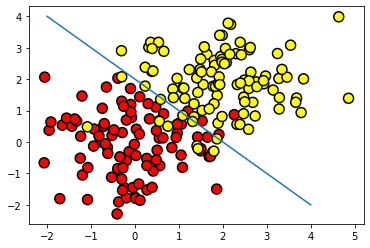

In [3]:

plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, s=100, 
cmap='autumn', edgecolors='black', linewidth=1.5);
plt.plot(range(-2,5), range(4,-3,-1));

In [4]:
# Вспомогательную функцию, которая будет возвращать решетку для дальнейшей визуализации.

def get_grid(data):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

In [5]:
# параметр min_samples_leaf указывает, при каком минимальном количестве
# элементов в узле он будет дальше разделяться
clf_tree = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=17)

In [6]:
# обучаем дерево
clf_tree.fit(train_data, train_labels)


DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=17)

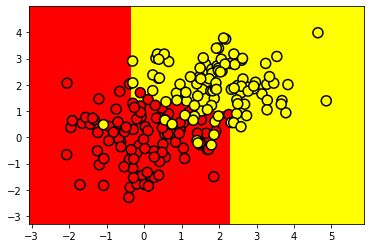

In [7]:
# код для отображения разделяющей поверхности
xx, yy = get_grid(train_data)

predicted = clf_tree.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.pcolormesh(xx, yy, predicted, cmap='autumn')
plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, s=100, 
cmap='autumn', edgecolors='black', linewidth=1.5);

### Деревья решений и метод ближайших соседей в задаче распознавания рукописных цифр MNIST

Используем "встроенные" в sklearn данные по рукописным цифрам

In [8]:
from sklearn.datasets import load_digits

df = load_digits()
X, y = df.data, df.target

X[0,:].reshape([8,8])

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

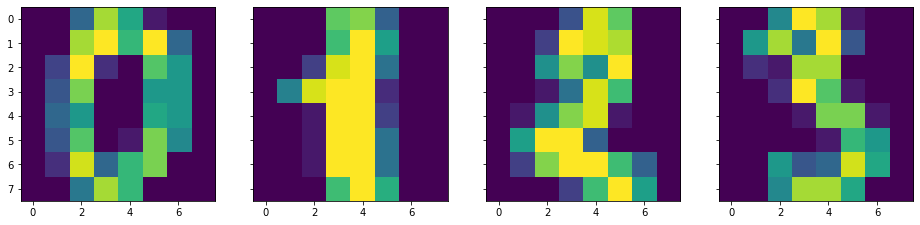

In [9]:
f, axes = plt.subplots(1, 4, sharey=True, figsize=(16,6))
for i in range(4):
    axes[i].imshow(X[i,:].reshape([8,8]));

 отложенная выборка

In [10]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.3,
random_state=17)

Обучаем дерево решений и KNN, параметры берем по умолчанию

In [11]:
tree = DecisionTreeClassifier(max_depth=5, random_state=17) 
tree.fit(X_train, y_train)


DecisionTreeClassifier(max_depth=5, random_state=17)

In [12]:
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=10)

In [13]:
tree_pred = tree.predict(X_holdout)

accuracy_score(y_holdout, tree_pred)

0.6666666666666666

In [14]:
knn_pred = knn.predict(X_holdout)

accuracy_score(y_holdout, knn_pred)

0.9740740740740741

настроим параметры моделей на кросс-валидации

In [15]:
tree_params = {'max_depth': [1, 2, 3, 5, 10, 20, 25, 30, 40, 50, 64],
'max_features': [1, 2, 3, 5, 10, 20 ,30, 50, 64]}

tree_grid = GridSearchCV(tree, tree_params, cv=5, n_jobs=-1, verbose=True)

tree_grid.fit(X_train, y_train)

Fitting 5 folds for each of 99 candidates, totalling 495 fits


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(max_depth=5, random_state=17),
             n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 5, 10, 20, 25, 30, 40, 50, 64],
                         'max_features': [1, 2, 3, 5, 10, 20, 30, 50, 64]},
             verbose=True)

In [16]:
tree_grid.best_params_, tree_grid.best_score_ 

({'max_depth': 10, 'max_features': 50}, 0.8568203376968316)

В случае одного ближайшего соседа на кросс-валидации достигается почти 99% угадываний

In [17]:
knn = KNeighborsClassifier(n_neighbors=1)

In [18]:
np.mean(cross_val_score(knn, X_train, y_train, cv=5))

0.9864858028204642

Обучим на этих же данных случайный лес, он на большинстве выборок работает лучше, чем метод ближайших соседей. Но сейчас у нас исключение

In [19]:
np.mean(cross_val_score(RandomForestClassifier(random_state=17), X_train, y_train, cv=5))

0.9753462341111744

Вывод: начинаем с проверки на своих данных простых моделей – дерево решений, метод ближайших соседей, логистической регрессии

### Набор данных "Adult"

классификация людей с помощью демографических данных для прогнозирования, зарабатывает ли человек более $ 50 000 в год.

Описание признаков:

* Age – возраст, количественный признак
* Workclass – тип работодателя, количественный признак
* fnlwgt – итоговый вес обьекта, количественный признак
* Education – уровень образования, качественный признак
* Education_Num – количество лет обучения, количественный признак
* Martial_Status – семейное положение, категориальный признак
* Occupation – профессия, категориальный признак
* Relationship – тип семейных отношений, категориальный признак
* Race – раса, категориальный признак
* Sex – пол, качественный признак
* Capital_Gain – прирост капитала, количественный признак
* Capital_Loss – потери капитала, количественный признак
* Hours_per_week – количество часов работы в неделю, количественный признак
* Country – страна, категориальный признак

Целевая переменная: Salary – уровень заработка, категориальный (бинарный) признак

In [20]:
data = pd.read_csv('adult.data.csv', sep=',') 

In [21]:
data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [22]:
X = data.drop(columns = ['salary'],axis = 1)
y = data['salary']

In [23]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.3, random_state=17)

In [24]:
y.map({"<=50K": 0, ">50K": 1}).head()

0    0
1    0
2    0
3    0
4    0
Name: salary, dtype: int64

In [25]:
X_train

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
10626,30,Private,78980,Assoc-voc,11,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States
24350,43,Private,247162,Assoc-acdm,12,Never-married,Sales,Own-child,White,Male,0,0,40,United-States
11454,25,Private,247006,Assoc-acdm,12,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States
6562,44,Private,138845,Some-college,10,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States
31618,42,Private,24982,Some-college,10,Married-civ-spouse,Craft-repair,Husband,White,Male,7688,0,40,United-States
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
406,28,Private,110145,HS-grad,9,Married-civ-spouse,Adm-clerical,Husband,White,Male,0,0,40,United-States
13702,18,Private,426895,12th,8,Never-married,Farming-fishing,Own-child,White,Male,0,0,55,United-States
2191,22,Private,355686,Some-college,10,Never-married,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States
31985,42,Self-emp-not-inc,126614,Bachelors,13,Divorced,Exec-managerial,Not-in-family,Other,Male,0,0,30,Iran


In [26]:
y_train

10626     >50K
24350    <=50K
11454    <=50K
6562     <=50K
31618     >50K
         ...  
406      <=50K
13702    <=50K
2191     <=50K
31985    <=50K
10863    <=50K
Name: salary, Length: 22792, dtype: object

### Первичный анализ данных

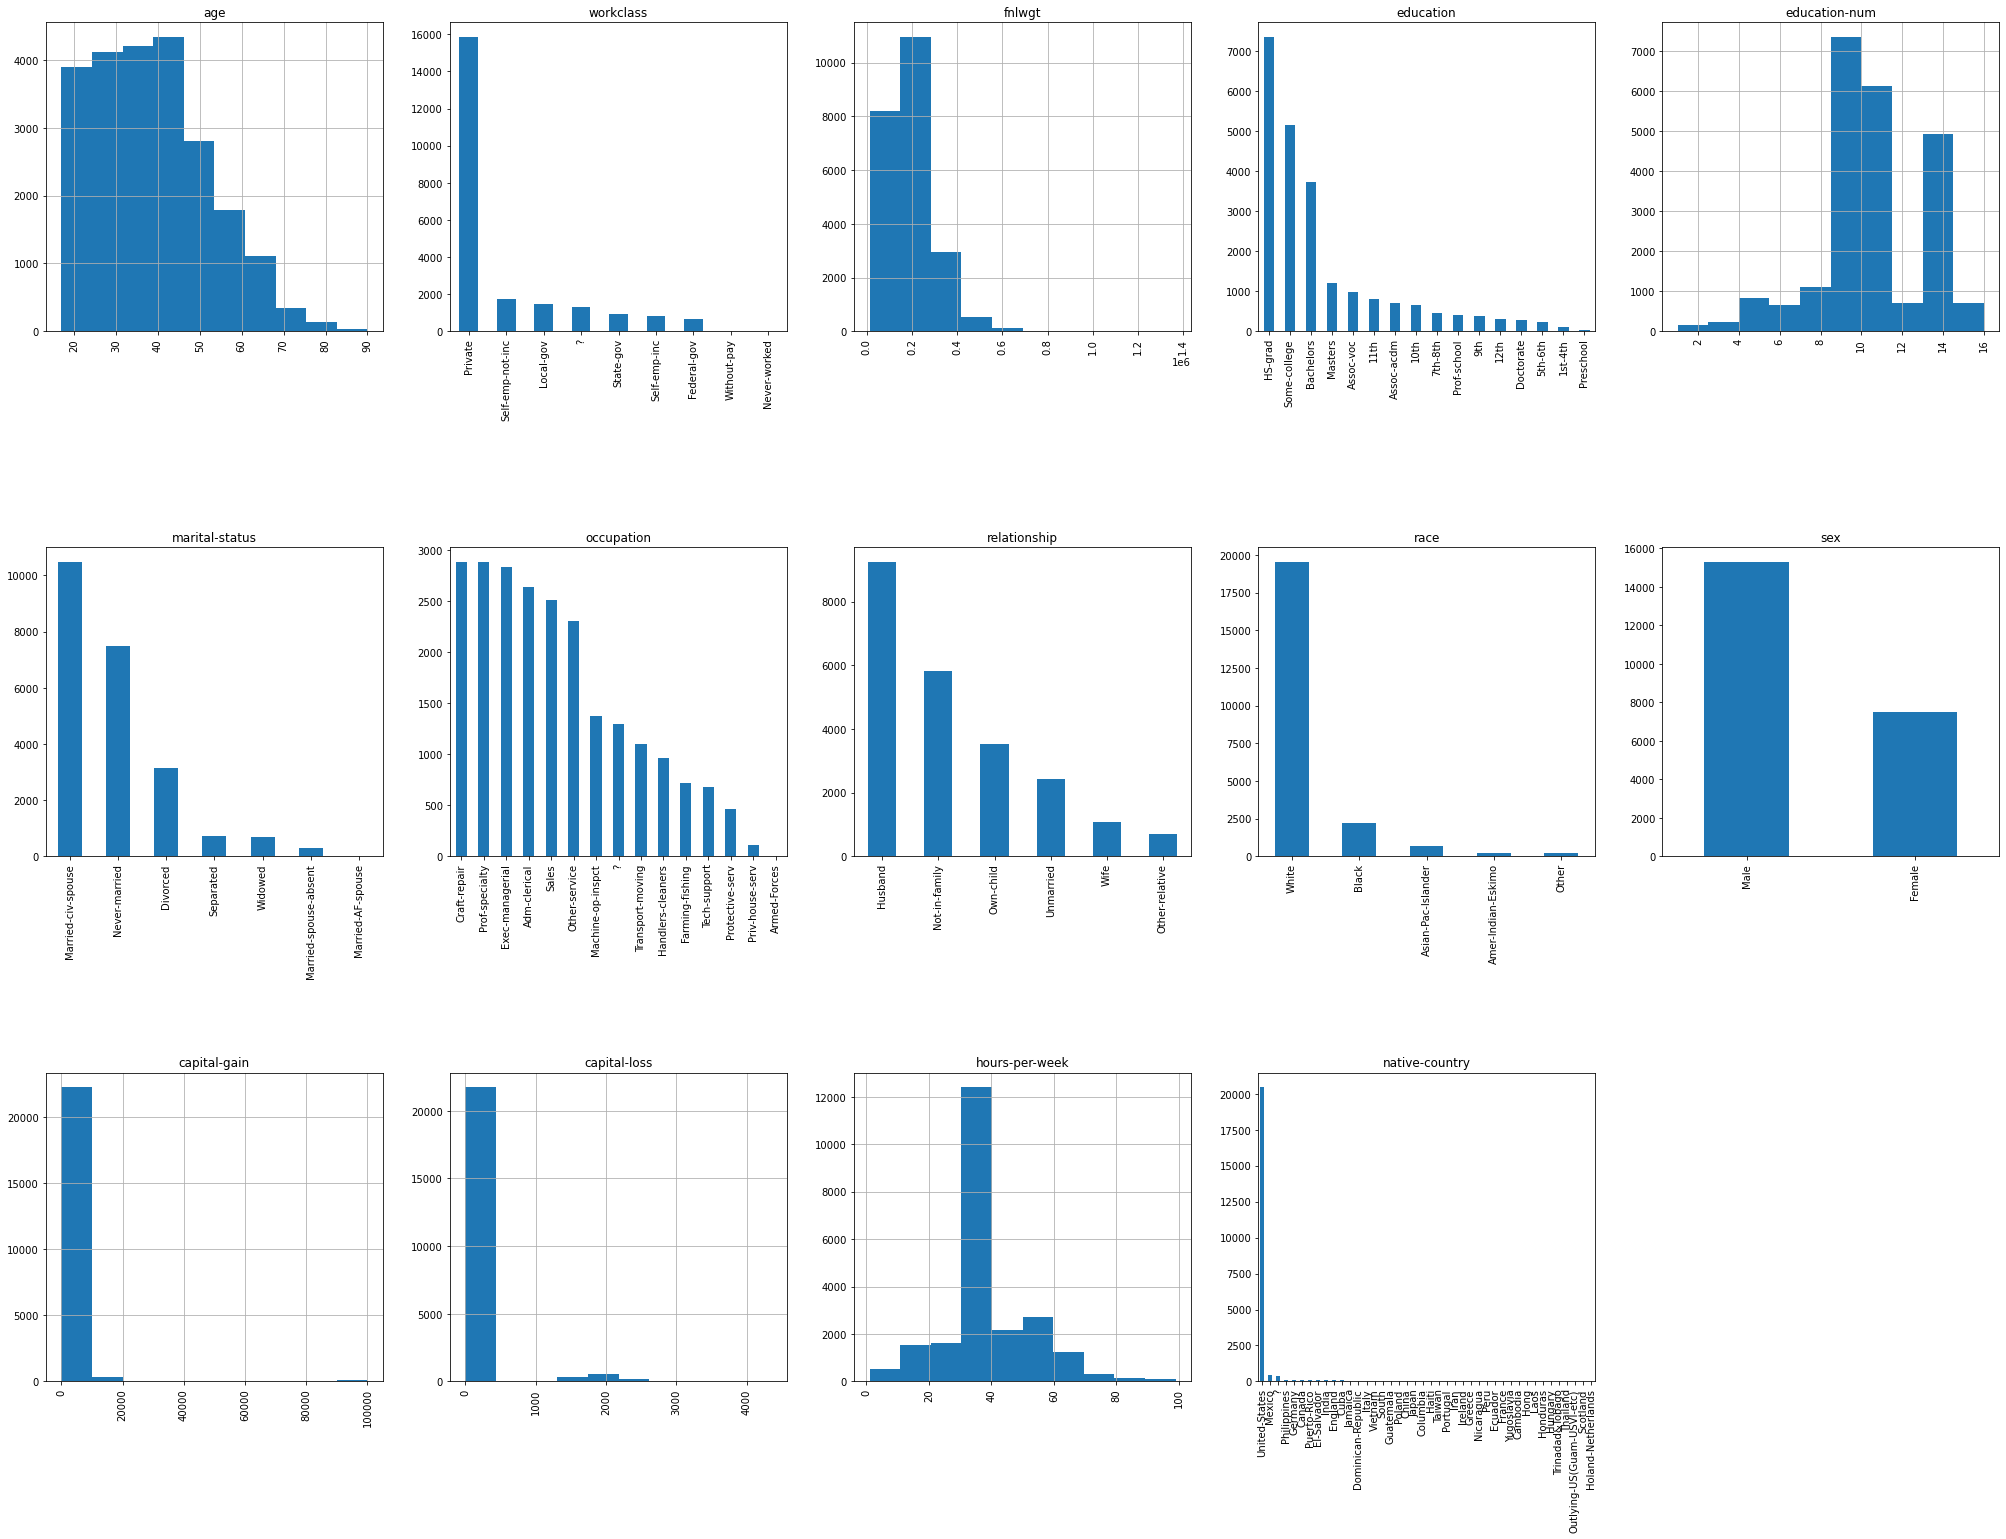

In [27]:
fig = plt.figure(figsize=(35, 25))
cols = 5
rows = int(np.ceil(float(X_train.shape[1]) / cols))
for i, column in enumerate(X_train.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    if X_train.dtypes[column] == np.object:
        X_train[column].value_counts().plot(kind="bar", axes=ax)
    else:
        X_train[column].hist(axes=ax)
        plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)

#### Проверка типов данных

In [28]:
X_train.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
dtype: object

In [29]:
X_holdout.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
dtype: object

In [30]:
X_holdout['age'] = X_holdout['age'].astype(int)

In [31]:
X_holdout['fnlwgt'] = X_holdout['fnlwgt'].astype(int)
X_holdout['education-num'] = X_holdout['education-num'].astype(int)
X_holdout['capital-gain'] = X_holdout['capital-gain'].astype(int)
X_holdout['capital-loss'] = X_holdout['capital-loss'].astype(int)
X_holdout['hours-per-week'] = X_holdout['hours-per-week'].astype(int)

Заполним пропуски в количественных признаках медианными значениями, а в категориальных – наиболее часто встречающимся значением

In [32]:
# выделим в выборках категориальные и числовые признаки

categorical_columns_train = [c for c in X_train.columns 
                             if X_train[c].dtype.name == 'object']
numerical_columns_train = [c for c in X_train.columns 
                           if X_train[c].dtype.name != 'object']

categorical_columns_test = [c for c in X_holdout.columns 
                            if X_holdout[c].dtype.name == 'object']
numerical_columns_test = [c for c in X_holdout.columns 
                          if X_holdout[c].dtype.name != 'object']

print('categorical_columns_test:', categorical_columns_test)
print('categorical_columns_train:', categorical_columns_train)
print('numerical_columns_test:', numerical_columns_test)
print('numerical_columns_train:', numerical_columns_train)

categorical_columns_test: ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
categorical_columns_train: ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
numerical_columns_test: ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
numerical_columns_train: ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']


In [33]:
# заполним пропуски

for c in categorical_columns_train:
    X_train[c] = X_train[c].fillna(X_train[c].mode())
for c in categorical_columns_test:
    X_holdout[c] = X_holdout[c].fillna(X_holdout[c].mode())
    
for c in numerical_columns_train:
    X_train[c] = X_train[c].fillna(X_train[c].median())
for c in numerical_columns_test:
    X_holdout[c] = X_holdout[c].fillna(X_holdout[c].median())    

Кодируем категориальные признаки 'Workclass', 'Education', 'Marital_Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Country'. Это можно сделать с помощью метода pandas get_dummies.

In [34]:
X_train = pd.concat([X_train, pd.get_dummies(X_train['workclass'], 
                                                   prefix="workclass"),
                      pd.get_dummies(X_train['education'], prefix="education"),
                      pd.get_dummies(X_train['marital-status'], prefix="marital-status"),
                      pd.get_dummies(X_train['occupation'], prefix="occupation"),
                      pd.get_dummies(X_train['relationship'], prefix="relationship"),
                      pd.get_dummies(X_train['race'], prefix="race"),
                      pd.get_dummies(X_train['sex'], prefix="sex"),
                      pd.get_dummies(X_train['native-country'], prefix="native-country")],
                     axis=1)

X_holdout = pd.concat([X_holdout, pd.get_dummies(X_holdout['workclass'], prefix="workclass"),
                      pd.get_dummies(X_holdout['education'], prefix="education"),
                      pd.get_dummies(X_holdout['marital-status'], prefix="marital-status"),
                      pd.get_dummies(X_holdout['occupation'], prefix="occupation"),
                      pd.get_dummies(X_holdout['relationship'], prefix="relationship"),
                      pd.get_dummies(X_holdout['race'], prefix="race"),
                      pd.get_dummies(X_holdout['sex'], prefix="sex"),
                      pd.get_dummies(X_holdout['native-country'], prefix="native-country")],
                     axis=1)

In [35]:
X_train.drop(['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country'], axis=1, inplace=True)

In [36]:
X_holdout.drop(['workclass', 'education', 'marital-status', 'occupation', 
                'relationship', 'race', 'sex', 'native-country'],
               axis=1, inplace=True)

In [37]:
X_train.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_?,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
10626,30,78980,11,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
24350,43,247162,12,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
11454,25,247006,12,0,0,45,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
6562,44,138845,10,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
31618,42,24982,10,7688,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [38]:
X_holdout.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
age,9769.0,38.565462,13.643879,17.0,28.0,37.0,48.0,90.0
fnlwgt,9769.0,189889.031528,106544.524590,14878.0,118686.0,177616.0,237819.0,1484705.0
education-num,9769.0,10.094175,2.573716,1.0,9.0,10.0,12.0,16.0
capital-gain,9769.0,1114.915652,7537.559743,0.0,0.0,0.0,0.0,99999.0
capital-loss,9769.0,88.584502,406.199517,0.0,0.0,0.0,0.0,4356.0
...,...,...,...,...,...,...,...,...
native-country_Thailand,9769.0,0.000819,0.028606,0.0,0.0,0.0,0.0,1.0
native-country_Trinadad&Tobago,9769.0,0.000921,0.030340,0.0,0.0,0.0,0.0,1.0
native-country_United-States,9769.0,0.892210,0.310131,0.0,1.0,1.0,1.0,1.0
native-country_Vietnam,9769.0,0.001843,0.042888,0.0,0.0,0.0,0.0,1.0


In [39]:
set(X_train.columns) - set(X_holdout.columns)

{'native-country_Holand-Netherlands'}

In [40]:
X_train.shape, X_holdout.shape

((22792, 108), (9769, 107))

В тестовой выборке не оказалось Голландии. Заведем необходимый признак из нулей.

In [41]:
X_holdout['native-country_Holand-Netherlands'] = np.zeros([X_holdout.shape[0], 1])

In [42]:
set(X_train.columns) - set(X_holdout.columns)

set()

In [43]:
X_train.head(2)

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_?,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
10626,30,78980,11,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
24350,43,247162,12,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [44]:
X_holdout.head(2)

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_?,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,...,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia,native-country_Holand-Netherlands
17121,54,284129,10,0,0,45,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0.0
363,43,174575,13,0,1564,45,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0.0


In [45]:
X_test = X_holdout
y_test = y_holdout

### Дерево решений без настройки параметров

In [46]:
tree = DecisionTreeClassifier(max_depth=3, random_state=17) 
tree.fit(X_train, y_train)


DecisionTreeClassifier(max_depth=3, random_state=17)

In [47]:
tree_pred = tree.predict(X_holdout)


In [48]:
accuracy_score(y_holdout, tree_pred)

0.8444057733647251

### Дерево решений с настройкой параметров

Обучите на имеющейся выборке дерево решений (DecisionTreeClassifier, опять random_state = 17 ). Максимальную глубину настройте на кросс-валидации с помощью GridSearchCV. Проведите 5-кратную кросс-валидацию

In [49]:
tree_params = {'max_depth': range(2,11)}

locally_best_tree = GridSearchCV(tree, tree_params, cv=5, n_jobs=-1, verbose=True)                     

locally_best_tree.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(max_depth=3, random_state=17),
             n_jobs=-1, param_grid={'max_depth': range(2, 11)}, verbose=True)

In [50]:
print("Best params:", locally_best_tree.best_params_)
print("Best cross validaton score", locally_best_tree.best_score_)

Best params: {'max_depth': 9}
Best cross validaton score 0.8570551131038894


Обучите на имеющейся выборке дерево решений максимальной глубины 9 (это лучшее значение max_depth в моем случае) и оцените долю правильных ответов на тесте. Используйте параметр random_state = 17 для воспроизводимости результатов.

In [51]:
tuned_tree = DecisionTreeClassifier(max_depth=9, random_state=17) 

In [52]:
tuned_tree.fit(X_train, y_train) 

DecisionTreeClassifier(max_depth=9, random_state=17)

In [53]:
tuned_tree_predictions = tuned_tree.predict(X_holdout)

In [54]:
accuracy_score(y_holdout, tuned_tree_predictions)

0.8574060804585935

### Случайный лес без настройки параметров

Обучите на имеющейся выборке случайный лес (RandomForestClassifier), число деревьев сделайте равным ста, а random_state = 17

In [55]:
rf = RandomForestClassifier(n_estimators=100, random_state=17)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=17)

In [56]:
forest_predictions = rf.predict(X_holdout)

In [57]:
accuracy_score(y_holdout, forest_predictions)

0.860067560651039

### Случайный лес с настройкой параметров

In [63]:
forest_params = {'max_depth': range(10, 15),
                'max_features': range(5, 35, 10)}

locally_best_forest = GridSearchCV(rf, forest_params, cv=5, n_jobs=-1, verbose=True)

locally_best_forest.fit(X_train, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=17), n_jobs=-1,
             param_grid={'max_depth': range(10, 15),
                         'max_features': range(5, 35, 10)},
             verbose=True)

In [64]:
print("Best params:", locally_best_forest.best_params_)
print("Best cross validaton score", locally_best_forest.best_score_)

Best params: {'max_depth': 14, 'max_features': 25}
Best cross validaton score 0.8642505395352302


прогноз для тестовой выборки

In [65]:
tuned_forest_predictions = locally_best_forest.predict(X_holdout)
accuracy_score(y_holdout, tuned_forest_predictions)

0.8627290408434845